In [36]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Move up one level in directory to allow module imports
import sys
sys.path.insert(0, '..')

# Import modules
from data.airport_dicts import *

In [2]:
# Define airports to select
market_airports = ["SEA", "SNA"]
market_coterms = ["LAX", "LGB", "BUR", "ONT"]
market_all_airports = market_airports + market_coterms

In [3]:
# Import average fare dataframe from static tables
average_city_fare_df = pd.read_csv("../data/table.csv")

# Filter for market airports
average_city_fare_df = average_city_fare_df[average_city_fare_df["Airport Code"].isin(market_all_airports)]

# Drop inflation column
average_city_fare_df.drop('Inflation Adjusted Average Fare ($) (Base Quarter:  Q2-2025)', axis=1, inplace=True)

average_city_fare_df

,2024 Passenger Rank,Airport Code,City Name,State Name,Average Fare ($)
0,1,LAX,Los Angeles,CA,413.68
7,8,SEA,Seattle,WA,400.25
46,47,SNA,Santa Ana,CA,406.95
52,53,ONT,Ontario,CA,375.80
54,55,BUR,Burbank,CA,316.68
73,74,LGB,Long Beach,CA,345.59


In [6]:
# Import market info dataframe from static tables
la_seattle_df = pd.read_csv("../data/la_to_seattle_t1_static.csv")

# Combine year and quarter, insert at front, and sort
period = la_seattle_df['year'].astype(str) + "Q" + la_seattle_df['quarter'].astype(str)
la_seattle_df.insert(0, 'period', period)
la_seattle_df.sort_values(by="period", ascending=True, inplace=True)

# Drop extra columns
la_seattle_df = la_seattle_df.drop(['quarter', 'city1', 'city2', 'nsmiles', 'citymarketid_1', 'citymarketid_2', 'table_1_flag', 'location_1', 'location_2', 'location_1_city', 'location_2_city'], axis=1)

# Calculate OA market share
la_seattle_df['OA_ms'] = np.where (
    la_seattle_df['carrier_lg'] == la_seattle_df['carrier_low'],
    1 - (la_seattle_df['large_ms']),
    1 - (la_seattle_df['large_ms'] + la_seattle_df["lf_ms"])
)

la_seattle_df

,period,year,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,OA_ms
117,1996Q1,1996,3760.100000,105.930000,AS,0.590000,110.500000,WN,0.100000,83.880000,0.310000
116,1996Q2,1996,4824.280000,109.190000,AS,0.580000,114.010000,WN,0.110000,72.440000,0.310000
115,1996Q3,1996,6121.840000,103.180000,AS,0.610000,107.410000,UA,0.180000,103.780000,0.210000
114,1996Q4,1996,4553.470000,104.060000,AS,0.560000,106.190000,UA,0.200000,104.950000,0.240000
113,1997Q1,1997,4081.880000,110.810000,AS,0.560000,109.360000,AS,0.560000,109.360000,0.440000
...,...,...,...,...,...,...,...,...,...,...,...
4,2024Q2,2024,7835.934066,199.847878,AS,0.620486,200.990948,AS,0.620486,200.990948,0.379514
3,2024Q3,2024,8595.543478,190.339173,AS,0.612792,194.774975,AS,0.612792,194.774975,0.387208
2,2024Q4,2024,7596.521739,196.851860,AS,0.625801,201.723470,AS,0.625801,201.723470,0.374199
1,2025Q1,2025,5838.666667,188.195690,AS,0.618216,192.284480,AS,0.618216,192.284480,0.381784


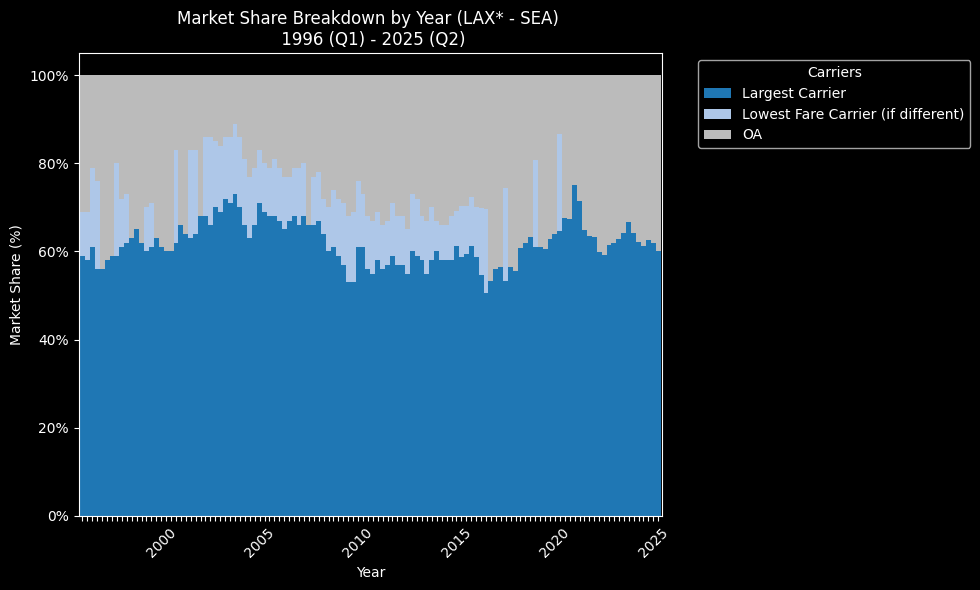

In [66]:
# Create helper column for plotting when largest carrier and lowest fare carrier are the same to prevent 2x graphing
la_seattle_df['lf_ms_plot'] = np.where(
    la_seattle_df['carrier_lg'] == la_seattle_df['carrier_low'],
    0,
    la_seattle_df['lf_ms']
)

# Stacked bar chart of main carrier, lowest fare carrier, and OA carriers
ax = la_seattle_df.set_index('period')[['large_ms', 'lf_ms_plot', 'OA_ms']].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#1f77b4', '#aec7e8', '#bbbbbb'],
    width=1.0
)

# Create labels for every 5 years
labels = []
last_labeled_year = None

for i, row in la_seattle_df.iterrows():
    year = int(row['year'])
    # Only label the first time we see a year divisible by 5
    if year % 5 == 0 and year != last_labeled_year:
        labels.append(str(year))
        last_labeled_year = year
    else:
        labels.append('')

ax.set_xticklabels(labels, rotation=45)

# Get date range for subtitle
min_quarter = min(la_seattle_df['period'])
max_quarter = max(la_seattle_df['period'])
subtitle = str(min_quarter[0:4]) + " (" + str(min_quarter[4:]) + ") - " + str(max_quarter[0:4]) + " (" + str(max_quarter[4:]) + ")"

# Formatting
plt.title(f'Market Share Breakdown by Year (LAX* - SEA) \n {subtitle}')
plt.ylabel('Market Share (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Year')
plt.legend(title='Carriers', bbox_to_anchor=(1.05, 1), loc='upper left', labels = ["Largest Carrier", "Lowest Fare Carrier (if different)", "OA",])
plt.tight_layout()